In [1]:
%matplotlib inline


Finetuning Torchvision Models
=============================

**Author:** `Nathan Inkawhich <https://github.com/inkawhich>`__




In this tutorial we will take a deeper look at how to finetune and
feature extract the `torchvision
models <https://pytorch.org/docs/stable/torchvision/models.html>`__, all
of which have been pretrained on the 1000-class Imagenet dataset. This
tutorial will give an indepth look at how to work with several modern
CNN architectures, and will build an intuition for finetuning any
PyTorch model. Since each model architecture is different, there is no
boilerplate finetuning code that will work in all scenarios. Rather, the
researcher must look at the existing architecture and make custom
adjustments for each model.

In this document we will perform two types of transfer learning:
finetuning and feature extraction. In **finetuning**, we start with a
pretrained model and update *all* of the model’s parameters for our new
task, in essence retraining the whole model. In **feature extraction**,
we start with a pretrained model and only update the final layer weights
from which we derive predictions. It is called feature extraction
because we use the pretrained CNN as a fixed feature-extractor, and only
change the output layer. For more technical information about transfer
learning see `here <http://cs231n.github.io/transfer-learning/>`__ and
`here <http://ruder.io/transfer-learning/>`__.

In general both transfer learning methods follow the same few steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the
   number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to
   update during training
-  Run the training step




In [3]:
from __future__ import print_function 
from __future__ import division
import pandas as pd
from skimage import io, transform
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import warnings
warnings.filterwarnings('ignore')
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


In [4]:
orientation_frame = pd.read_csv('orientation_data/regression/Train/orientation_labels.txt', sep=" ", header=None)
orientation_frame.columns = ["ImageName", "Label", "ang_obs", "orientation"]
n=len(orientation_frame)

In [5]:
def show_pic(image, angle):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.title(str(angle))
#     plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [6]:
class AnglesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.angle_frame = pd.read_csv(csv_file,sep=" ", header=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.angle_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.angle_frame.iloc[idx, 0])
        image = io.imread(img_name)
        angle = self.angle_frame.iloc[idx, 2]
        sample = {'image': image, 'angle': angle}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, angle = sample['image'], sample['angle']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

#         # h and w are swapped for landmarks because for images,
#         # x and y axes are axis 1 and 0 respectively
#         landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'angle': angle}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, angle = sample['image'], sample['angle']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        if h-new_h<0:
            top=0
            left=0
        else:
            top = np.random.randint(0, h - new_h)
            left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h,
                      left: left + new_w]

        

        return {'image': image, 'angle': angle}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, angle = sample['image'], sample['angle']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'angle': torch.from_numpy(np.asarray(angle))}

# class Normalize(object):
#     def __init__(self, output_size):
#     assert isinstance(output_size, (int, tuple))
#     self.output_size = output_size

#     def __call__(self, sample):
#         image, angle = sample['image'], sample['angle']
#         if isinstance(self.output_size, int):
            
#         img = transform.Normalize(image, (new_h, new_w))

# #         # h and w are swapped for landmarks because for images,
# #         # x and y axes are axis 1 and 0 respectively
# #         landmarks = landmarks * [new_w / w, new_h / h]

#         return {'image': img, 'angle': angle}

Inputs
------

Here are all of the parameters to change for the run. We will use the
*hymenoptera_data* dataset which can be downloaded
`here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`__.
This dataset contains two classes, **bees** and **ants**, and is
structured such that we can use the
`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset, rather than writing our own custom dataset. Download the data
and set the ``data_dir`` input to the root directory of the dataset. The
``model_name`` input is the name of the model you wish to use and must
be selected from this list:

::

   [resnet, alexnet, vgg, squeezenet, densenet, inception]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs we want to run,
and ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting. If ``feature_extract = False``, the model is
finetuned and all model parameters are updated. If
``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.




In [8]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./orientation_data"
# data_dir = "./hymenoptera_data"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 1

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for 
num_epochs = 200

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

Helper Functions
----------------

Before we write the code for adjusting the models, lets define a few
helper functions.

Model Training and Validation Code
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model. The *is_inception* flag is used to accomodate the
*Inception v3* model, as that architecture uses an auxiliary output and
the overall model loss respects both the auxiliary output and the final
output, as described
`here <https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958>`__.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.




In [52]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc=[]
    train_loss=[]
    val_loss=[]
    best_model_wts = copy.deepcopy(model.state_dict())
    model_last=copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss=300.00




    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Val','Train']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for ibatch, sample_batched in enumerate(dataloaders[phase]):
                inputs=sample_batched['image']
                labels=sample_batched['angle']
                inputs = inputs.type(torch.cuda.FloatTensor) 
                print('inputs shape:', inputs.size())
                labels = labels.type(torch.cuda.FloatTensor) 
#                 print('label size',labels.size()[0])
                labels=labels.view(labels.size()[0], -1)
#                 print('input type',inputs.type())
#                 print('labels type',labels.type())
#                 print('labels size',labels.size())
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'Train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #need to edit the running corrects
#                 running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_acc=0
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'Train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                with open("train_loss.txt", "a") as myfile:
                    myfile.write(str(epoch_loss)+"\n")
            # deep copy the model
            if phase == 'Val' and  epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'Val':
                val_acc_history.append(epoch_acc)
                val_loss.append(epoch_loss)
                with open("val_loss.txt", "a") as myfile:
                    myfile.write(str(epoch_loss) + "\n")

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model_last_wts=copy.deepcopy(model.state_dict())
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_loss, val_loss, train_acc, model_last_wts

Set Model Parameters’ .requires_grad attribute
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Initialize and Reshape the Networks
-----------------------------------

Now to the most interesting part. Here is where we handle the reshaping
of each network. Note, this is not an automatic procedure and is unique
to each model. Recall, the final layer of a CNN model, which is often
times an FC layer, has the same number of nodes as the number of output
classes in the dataset. Since all of the models have been pretrained on
Imagenet, they all have output layers of size 1000, one node for each
class. The goal here is to reshape the last layer to have the same
number of inputs as before, AND to have the same number of outputs as
the number of classes in the dataset. In the following sections we will
discuss how to alter the architecture of each model individually. But
first, there is one important detail regarding the difference between
finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the
last layer, or in other words, we only want to update the parameters for
the layer(s) we are reshaping. Therefore, we do not need to compute the
gradients of the parameters that we are not changing, so for efficiency
we set the .requires_grad attribute to False. This is important because
by default, this attribute is set to True. Then, when we initialize the
new layer and by default the new parameters have ``.requires_grad=True``
so only the new layer’s parameters will be updated. When we are
finetuning we can leave all of the .required_grad’s set to the default
of True.

Finally, notice that inception_v3 requires the input size to be
(299,299), whereas all of the other models expect (224,224).

Resnet
~~~~~~

Resnet was introduced in the paper `Deep Residual Learning for Image
Recognition <https://arxiv.org/abs/1512.03385>`__. There are several
variants of different sizes, including Resnet18, Resnet34, Resnet50,
Resnet101, and Resnet152, all of which are available from torchvision
models. Here we use Resnet18, as our dataset is small and only has two
classes. When we print the model, we see that the last layer is a fully
connected layer as shown below:

::

   (fc): Linear(in_features=512, out_features=1000, bias=True) 

Thus, we must reinitialize ``model.fc`` to be a Linear layer with 512
input features and 2 output features with:

::

   model.fc = nn.Linear(512, num_classes)

Alexnet
~~~~~~~

Alexnet was introduced in the paper `ImageNet Classification with Deep
Convolutional Neural
Networks <https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf>`__
and was the first very successful CNN on the ImageNet dataset. When we
print the model architecture, we see the model output comes from the 6th
layer of the classifier

::

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    ) 

To use the model with our dataset we reinitialize this layer as

::

   model.classifier[6] = nn.Linear(4096,num_classes)

VGG
~~~

VGG was introduced in the paper `Very Deep Convolutional Networks for
Large-Scale Image Recognition <https://arxiv.org/pdf/1409.1556.pdf>`__.
Torchvision offers eight versions of VGG with various lengths and some
that have batch normalizations layers. Here we use VGG-11 with batch
normalization. The output layer is similar to Alexnet, i.e.

::

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )

Therefore, we use the same technique to modify the output layer

::

   model.classifier[6] = nn.Linear(4096,num_classes)

Squeezenet
~~~~~~~~~~

The Squeeznet architecture is described in the paper `SqueezeNet:
AlexNet-level accuracy with 50x fewer parameters and <0.5MB model
size <https://arxiv.org/abs/1602.07360>`__ and uses a different output
structure than any of the other models shown here. Torchvision has two
versions of Squeezenet, we use version 1.0. The output comes from a 1x1
convolutional layer which is the 1st layer of the classifier:

::

   (classifier): Sequential(
       (0): Dropout(p=0.5)
       (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
       (2): ReLU(inplace)
       (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
    ) 

To modify the network, we reinitialize the Conv2d layer to have an
output feature map of depth 2 as

::

   model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

Densenet
~~~~~~~~

Densenet was introduced in the paper `Densely Connected Convolutional
Networks <https://arxiv.org/abs/1608.06993>`__. Torchvision has four
variants of Densenet but here we only use Densenet-121. The output layer
is a linear layer with 1024 input features:

::

   (classifier): Linear(in_features=1024, out_features=1000, bias=True) 

To reshape the network, we reinitialize the classifier’s linear layer as

::

   model.classifier = nn.Linear(1024, num_classes)

Inception v3
~~~~~~~~~~~~

Finally, Inception v3 was first described in `Rethinking the Inception
Architecture for Computer
Vision <https://arxiv.org/pdf/1512.00567v1.pdf>`__. This network is
unique because it has two output layers when training. The second output
is known as an auxiliary output and is contained in the AuxLogits part
of the network. The primary output is a linear layer at the end of the
network. Note, when testing we only consider the primary output. The
auxiliary output and primary output of the loaded model are printed as:

::

   (AuxLogits): InceptionAux(
       ...
       (fc): Linear(in_features=768, out_features=1000, bias=True)
    )
    ...
   (fc): Linear(in_features=2048, out_features=1000, bias=True)

To finetune this model we must reshape both layers. This is accomplished
with the following

::

   model.AuxLogits.fc = nn.Linear(768, num_classes)
   model.fc = nn.Linear(2048, num_classes)

Notice, many of the models have similar output structures, but each must
be handled slightly differently. Also, check out the printed model
architecture of the reshaped network and make sure the number of output
features is the same as the number of classes in the dataset.




In [30]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 1)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [13]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
#         transforms.RandomResizedCrop(input_size),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [14]:
image_datasets={'Train':AnglesDataset(csv_file='orientation_data/regression/Train/orientation_labels.txt',
                                    root_dir='orientation_data/regression/Train/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(200),
                                               ToTensor()
                                           ]))}
image_datasets['Val']=AnglesDataset(csv_file='orientation_data/regression/Val/orientation_labels.txt',
                                    root_dir='orientation_data/regression/Val/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(200),
                                               ToTensor()
                                           ]))
print(image_datasets)

dataloaders_dict = {'Train':DataLoader(image_datasets['Train'], batch_size=32,shuffle=True, num_workers=4)}
dataloaders_dict['Val'] = DataLoader(image_datasets['Val'], batch_size=32,shuffle=True, num_workers=4)

print("Initializing Datasets and Dataloaders...")
print(dataloaders_dict)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


{'Train': <__main__.AnglesDataset object at 0x7f63be807d30>, 'Val': <__main__.AnglesDataset object at 0x7f63be807b70>}
Initializing Datasets and Dataloaders...
{'Train': <torch.utils.data.dataloader.DataLoader object at 0x7f63be807be0>, 'Val': <torch.utils.data.dataloader.DataLoader object at 0x7f63be9acc18>}


In [15]:
print(device)
print(image_datasets)
print(dataloaders_dict)

cuda:0
{'Train': <__main__.AnglesDataset object at 0x7f63be807d30>, 'Val': <__main__.AnglesDataset object at 0x7f63be807b70>}
{'Train': <torch.utils.data.dataloader.DataLoader object at 0x7f63be807be0>, 'Val': <torch.utils.data.dataloader.DataLoader object at 0x7f63be9acc18>}


Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [32]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [53]:
# Setup the loss fxn
criterion = nn.MSELoss()
num_epochs=100
# Train and evaluate
model_ft, hist, train_hist, val_hist, train_acc, model_last = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs, is_inception=(model_name=="inception"))

Epoch 0/99
----------
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs sha

Process Process-878:
Process Process-879:
Process Process-877:
Traceback (most recent call last):
  File "/home/cad297/.conda/envs/cad297/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/cad297/.conda/envs/cad297/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-880:
  File "/home/cad297/.conda/envs/cad297/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/cad297/.conda/envs/cad297/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
Traceback (most recent call last):
  File "/home/cad297/.conda/envs/cad297/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/ho

inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])
inputs shape: torch.Size([32, 3, 200, 200])


KeyboardInterrupt: 

In [34]:
train_all_hist=[];
val_all_hist=[];

In [35]:
train_all_hist.append(train_hist)
val_all_hist.append(val_hist)
total_epochs=len(train_all_hist[0])

In [36]:
print(len(train_all_hist))
print(len(val_all_hist))
print(total_epochs)

1
1
100


In [37]:
torch.save(model_ft.state_dict(), 'resnet18_nov19_1.pt')

In [22]:
model_ft.load_state_dict(torch.load('resnet18_nov1_2.pt'))

Comparison with Model Trained from Scratch
------------------------------------------

Just for fun, lets see how the model learns if we do not use transfer
learning. The performance of finetuning vs. feature extracting depends
largely on the dataset but in general both transfer learning methods
produce favorable results in terms of training time and overall accuracy
versus a model trained from scratch.




Epoch 0/14
----------
train Loss: 0.6659 Acc: 0.6293
val Loss: 0.6823 Acc: 0.6533

Epoch 1/14
----------
train Loss: 0.6003 Acc: 0.6830
val Loss: 0.5524 Acc: 0.7267

Epoch 2/14
----------
train Loss: 0.5366 Acc: 0.7448
val Loss: 0.5156 Acc: 0.7067

Epoch 3/14
----------
train Loss: 0.4890 Acc: 0.7678
val Loss: 0.4713 Acc: 0.8000

Epoch 4/14
----------
train Loss: 0.4327 Acc: 0.7993
val Loss: 0.4446 Acc: 0.8067

Epoch 5/14
----------
train Loss: 0.3812 Acc: 0.8330
val Loss: 0.4123 Acc: 0.8167

Epoch 6/14
----------
train Loss: 0.3546 Acc: 0.8470
val Loss: 0.3605 Acc: 0.8400

Epoch 7/14
----------
train Loss: 0.3312 Acc: 0.8574
val Loss: 0.4516 Acc: 0.8300

Epoch 8/14
----------
train Loss: 0.2713 Acc: 0.8785
val Loss: 0.4215 Acc: 0.8400

Epoch 9/14
----------
train Loss: 0.2538 Acc: 0.8885
val Loss: 0.3596 Acc: 0.8767

Epoch 10/14
----------
train Loss: 0.2120 Acc: 0.9163
val Loss: 0.4779 Acc: 0.8333

Epoch 11/14
----------
train Loss: 0.1794 Acc: 0.9278
val Loss: 0.4700 Acc: 0.8233

Ep

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cad297/.conda/envs/cad297/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
  File "/home/cad297/.conda/envs/cad297/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/cad297/.conda/envs/cad297/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
  File "/home/cad297/.conda/envs/cad297/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/home/cad297/.conda/envs/cad297/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/cad297/.conda/envs/cad297/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/home/cad297/.conda/envs/cad297/lib/python3.6/multiprocessing/queues.py", line 230, in 

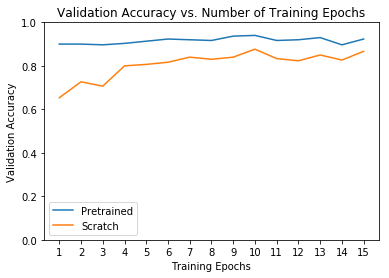

In [90]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist,_,_,_ = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()


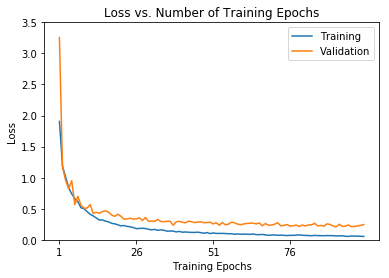

In [38]:
fig1=plt.figure()
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
# ohist = [h.cpu().numpy() for h in hist]
num_epochs=100
plt.plot(range(1,num_epochs+1),train_hist,label="Training")
plt.plot(range(1,num_epochs+1),val_hist,label="Validation")
plt.ylim((0,3.5))
plt.xticks(np.arange(1, num_epochs+1,25))
plt.legend()
plt.show()
fig1.savefig('regression_loss.png', bbox_inches='tight')
# # train_list = [h.cpu().numpy() for h in train_acc]
# fig2=plt.figure()
# plt.title("Error Rate vs. Number of Training Epochs")
# plt.xlabel("Training Epochs")
# plt.ylabel("Error Rate")
# plt.plot(range(1,num_epochs+1),np.ones(len(train_list))-train_list,label="Training")
# plt.plot(range(1,num_epochs+1),np.ones(len(train_list))-ohist,label="Validation")
# plt.ylim((0,0.25))
# plt.xticks(np.arange(1, num_epochs+1, 1.0))
# plt.legend()
# fig2.savefig('error_rate2.png', bbox_inches='tight')

In [129]:
data_dir = "./orientation_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [39]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for ibatch, sample_batched in enumerate(dataloaders_dict['Val']):
            inputs=sample_batched['image']
            labels=sample_batched['angle']
            inputs = inputs.type(torch.cuda.FloatTensor) 
            labels = labels.type(torch.cuda.FloatTensor) 
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels=[p.cpu().numpy() for p in labels]
            outputs = model(inputs)
            preds_vec=[m.cpu().numpy() for m in outputs]
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(preds_vec[j]))
                print('Predicted:', preds_vec[j][0], 'GroundTruth:',true_labels[j] )
                print(np.shape(inputs.cpu().data[j].numpy()))
                img=inputs.cpu().data[j]
                plt.imshow(img.permute(1, 2, 0).numpy())
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [40]:
def eval_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    errors=[]
    gt_labels=[]
    with torch.no_grad():
        for ibatch, sample_batched in enumerate(dataloaders_dict['Val']):
            inputs=sample_batched['image']
            labels=sample_batched['angle']
            inputs = inputs.type(torch.cuda.FloatTensor) 
            labels = labels.type(torch.cuda.FloatTensor) 
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels=[p.cpu().numpy() for p in labels]
            outputs = model(inputs)
            preds_vec=[m.cpu().numpy() for m in outputs]
            preds_vec=np.asarray(preds_vec)
            true_labels=np.asarray(true_labels)
            error=np.abs(preds_vec.T-true_labels)
            errors.append(error)
            gt_labels.append(np.asarray(true_labels))
#             for j in range(inputs.size()[0]):
#                 images_so_far += 1
#                 if images_so_far == num_images:
#                     model.train(mode=was_training)
#                     return errors, gt_labels
        return errors, gt_labels
        model.train(mode=was_training)

Predicted: 1.6287321 GroundTruth: 1.64
(3, 200, 200)
Predicted: -1.8700337 GroundTruth: -1.87
(3, 200, 200)
Predicted: -1.8494735 GroundTruth: -2.67
(3, 200, 200)
Predicted: -1.9829336 GroundTruth: -1.93
(3, 200, 200)
Predicted: -1.3415323 GroundTruth: -1.06
(3, 200, 200)
Predicted: -1.3450743 GroundTruth: -1.34
(3, 200, 200)


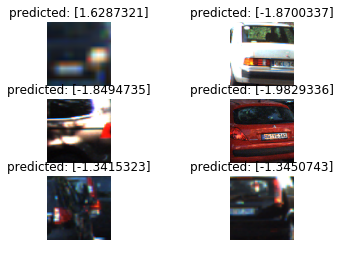

In [41]:
visualize_model(model_ft)

In [42]:
errors, gt_labels=eval_model(model_ft, num_images=33)
errors=np.hstack(np.hstack(errors))
print(np.shape(errors))
# errors=np.concatenate(np.concatenate(np.asarray(errors)))
print('Errors',errors, 'Number of samples',len(errors), 'Mean Squared Error', np.mean(errors))
gt_labels=np.concatenate(np.asarray(gt_labels))
print('gt_labels',gt_labels, len(gt_labels))
# print(np.shape(np.concatenate(np.concatenate(np.asarray(errors)))))

(3275,)
Errors [8.7360817e-01 1.7328620e-02 3.0042908e+00 ... 1.5881062e-03 3.2885790e-02
 2.1289349e-02] Number of samples 3275 Mean Squared Error 0.19882108
gt_labels [-1.63 -1.77 -2.87 ... -1.46 -1.37  2.17] 3275


[ 9  8  2 ... 10 11 31]


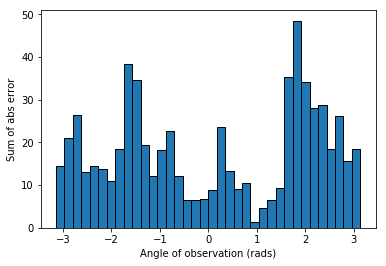

In [43]:
#Histogram generation
bins=np.arange(-np.pi,np.pi+2*np.pi/36,2*np.pi/36)
n, bins, patches = plt.hist(gt_labels,bins ,edgecolor='k', weights=errors)
index=np.digitize(gt_labels, bins)
print(index)
plt.xlabel('Angle of observation (rads)')
plt.ylabel('Sum of abs error')
# plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
# plt.axis([-np.pi, 160, 0, 0.03])
# plt.grid(True)
plt.show()

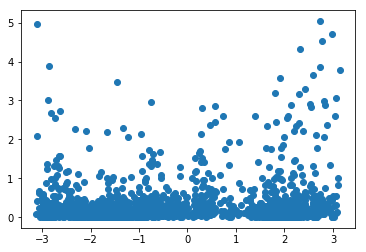

In [44]:
plt.scatter(gt_labels,errors)

[0.44940804 0.4024685  0.46351982 0.29455374 0.23365745 0.21530858
 0.13090045 0.1003497  0.08260612 0.09859985 0.15960538 0.14028866
 0.19502461 0.34983042 0.30603    0.21666547 0.25490235 0.32502723
 0.33820551 0.55963391 0.43250011 0.91955208 0.58671265 0.13301851
 0.52588538 0.21014359 0.25398995 0.11391275 0.12501312 0.15790968
 0.27498365 0.48574947 0.57624715 0.67351278 0.8263133  1.08750664]


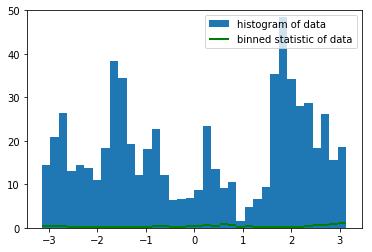

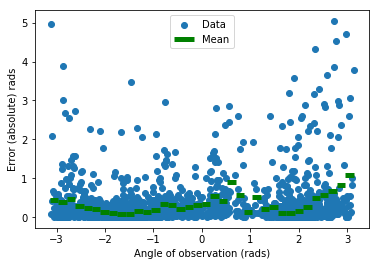

In [47]:
from scipy import stats
bin_means, bin_edges, binnumber = stats.binned_statistic(gt_labels,errors,statistic='mean', bins=bins)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
print(bin_means)
plt.figure()
plt.hist(gt_labels, bins=bins,weights=errors, histtype='stepfilled',label='histogram of data')
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,label='binned statistic of data')
# >plt.plot((binnumber - 0.5) * bin_width, x_pdf, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.ylim(0, 50)
plt.show()
plt.figure()
plt.scatter(gt_labels,errors, label='Data')
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5,label='Mean')
plt.xlabel('Angle of observation (rads)')
plt.ylabel('Error (absolute) rads')
plt.legend(fontsize=10)

In [219]:
#Testing validation set just on pretrained
data_dir = "./orientation_data"
# data_dir = "./hymenoptera_data"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False
model_ft2, input_size2 = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft2 = model_ft2.to(device)
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


In [254]:
acc=eval_model(model_ft2,13000)
print(acc)


0.5396153846153846


In [244]:
acc2=eval_model(model_ft,13000)
print(acc2)

0.9739230769230769


Final Thoughts and Where to Go Next
-----------------------------------

Try running some of the other models and see how good the accuracy gets.
Also, notice that feature extracting takes less time because in the
backward pass we do not have to calculate most of the gradients. There
are many places to go from here. You could:

-  Run this code with a harder dataset and see some more benefits of
   transfer learning
-  Using the methods described here, use transfer learning to update a
   different model, perhaps in a new domain (i.e. NLP, audio, etc.)
-  Once you are happy with a model, you can export it as an ONNX model,
   or trace it using the hybrid frontend for more speed and optimization
   opportunities.


